# Preprocessing and clustering 3k PBMCs

In [1]:
# download data
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: data: File exists
--2023-10-24 22:20:35--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
正在解析主机 cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:1ad, 2606:4700::6812:ad, 104.18.1.173, ...
正在连接 cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:1ad|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 301 Moved Permanently
位置：https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [跟随至新的 URL]
--2023-10-24 22:20:35--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
正在连接 cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:1ad|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：7621991 (7.3M) [application/x-tar]
正在保存至: “data/pbmc3k_filtered_gene_bc_matrices.tar.gz”

data/pbmc3k_filtere 100%[===================>]   7.27M  31.5MB/s  用时 0.2s      

2023-10-24 22:20:36 (31.5 MB/s) - 已保存 “data/pbmc3k_filtered_gene_bc_matrices.tar.gz” [7621991/7621991])

mkdi

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.24.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [4]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [5]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


:::{note}
See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.
:::

In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


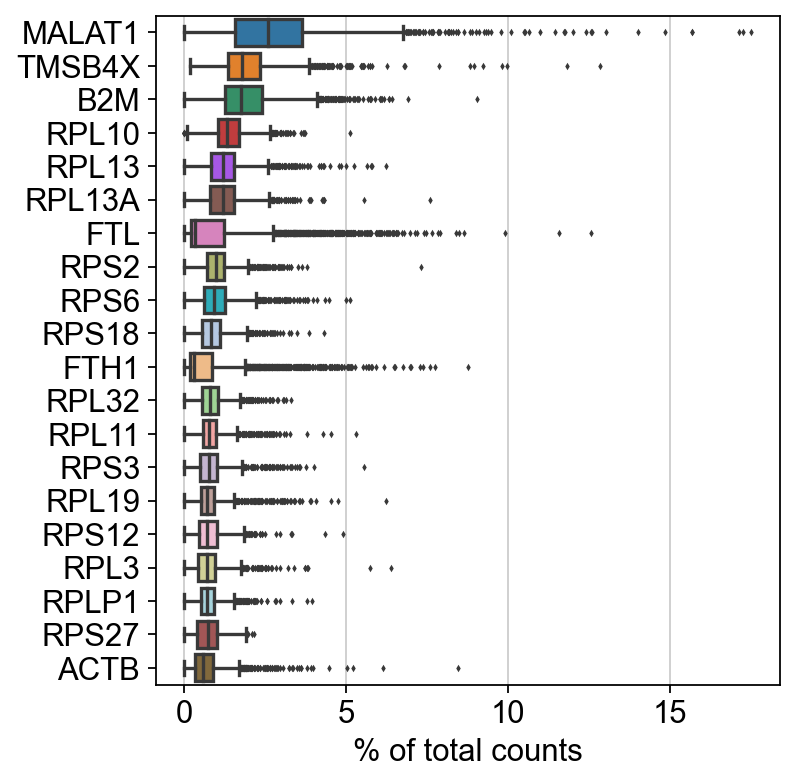

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

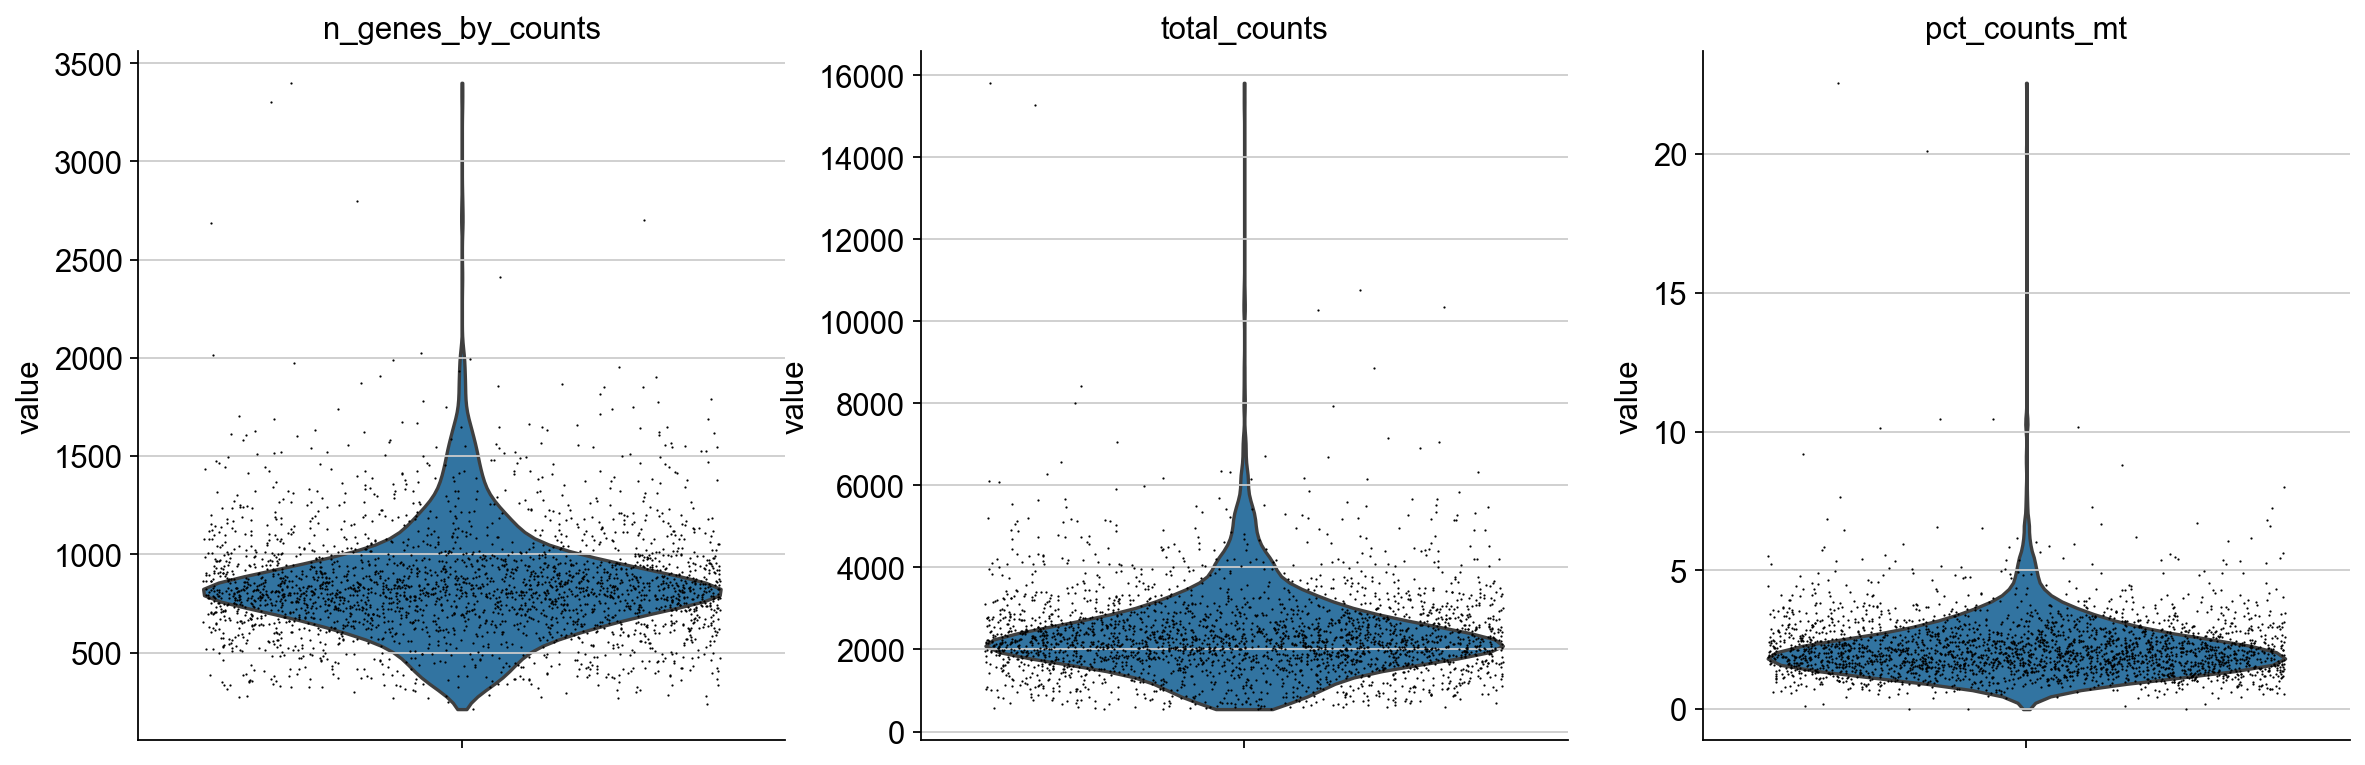

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

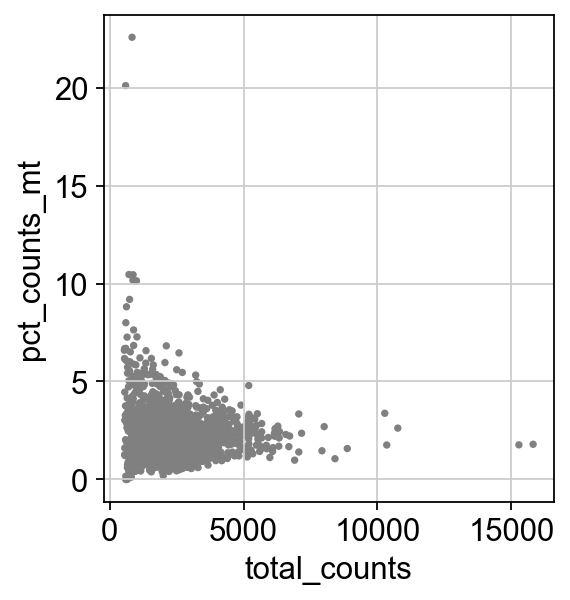

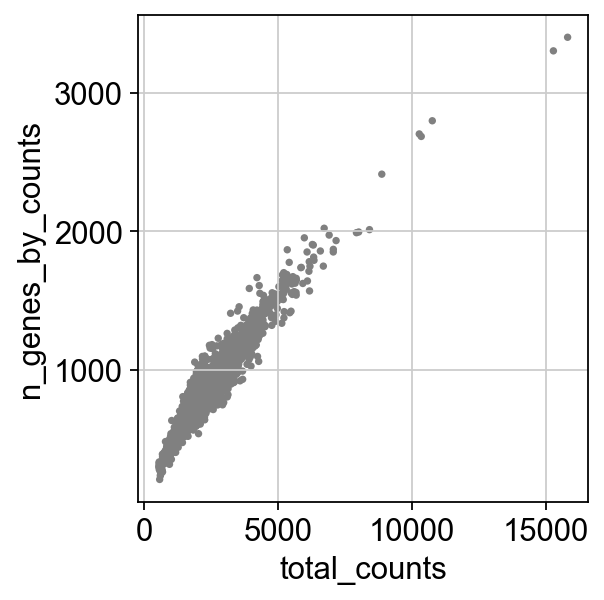

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pp.log1p(adata) #Logarithmize the data

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #Identify highly-variable genes.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


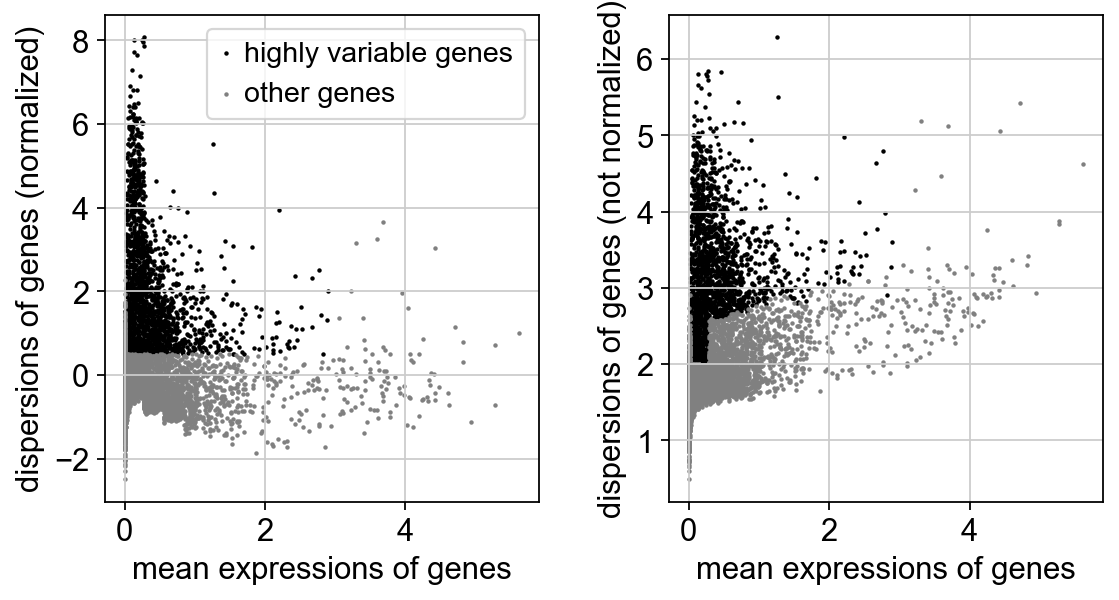

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:01)


In [21]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


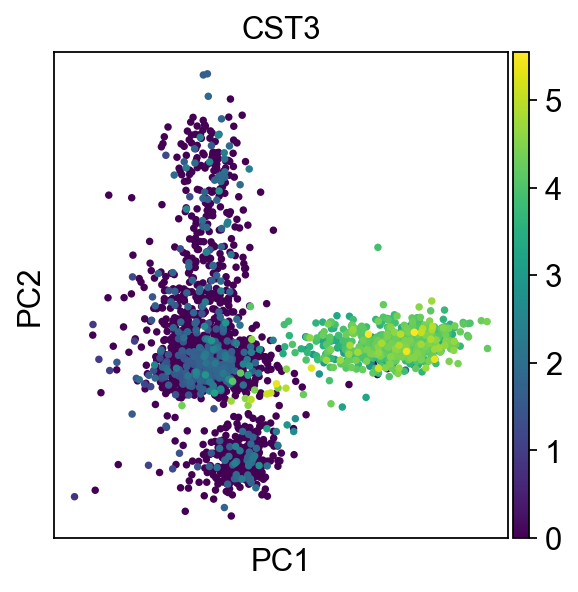

In [23]:
sc.pl.pca(adata, color='CST3')

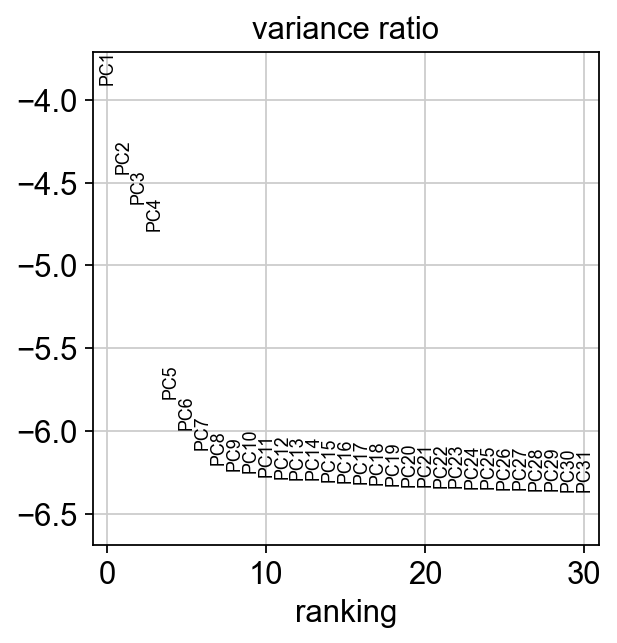

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
adata.write(results_file)

In [26]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph

In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


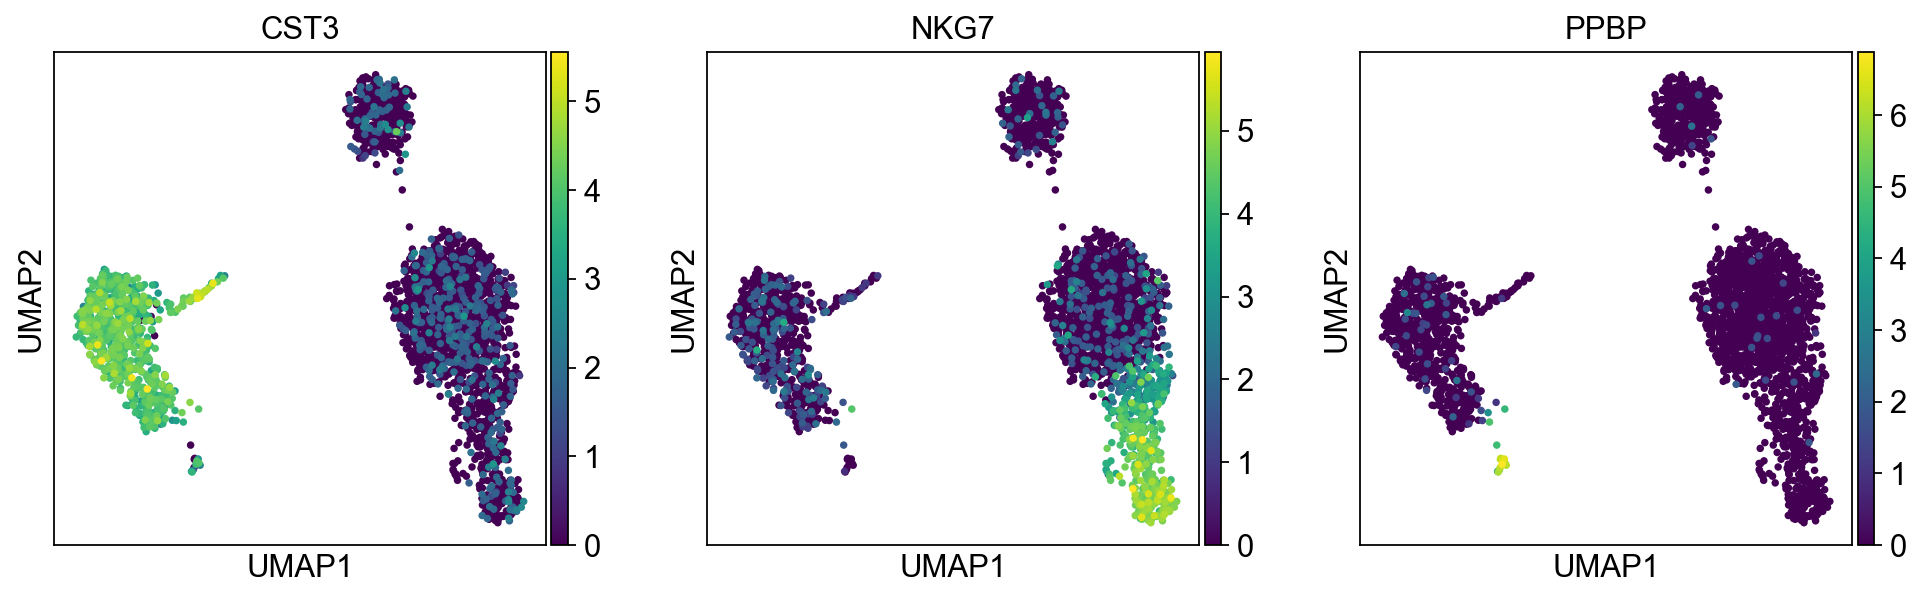

In [29]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

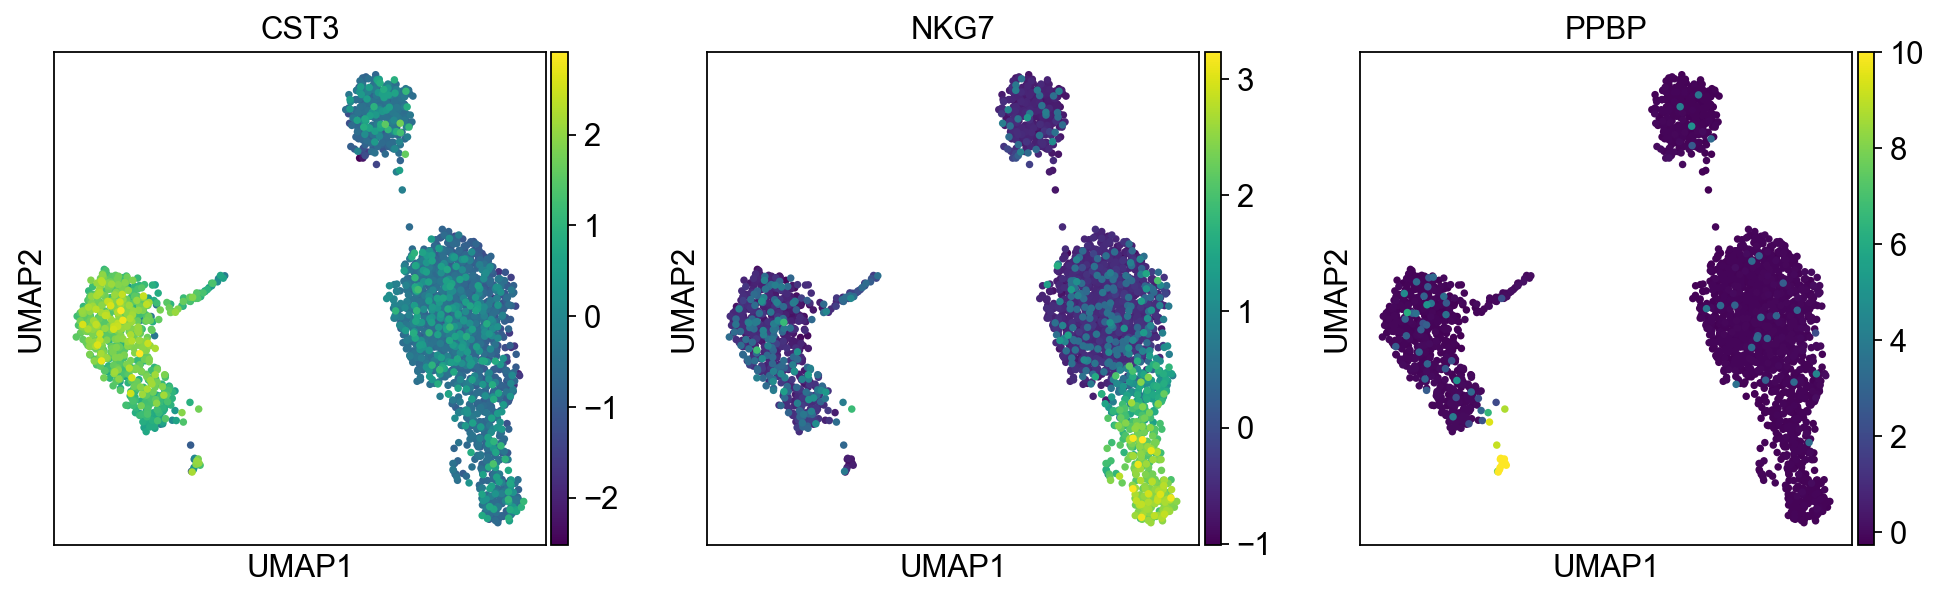

In [30]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

In [31]:
sc.tl.leiden(adata, resolution=0.9)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


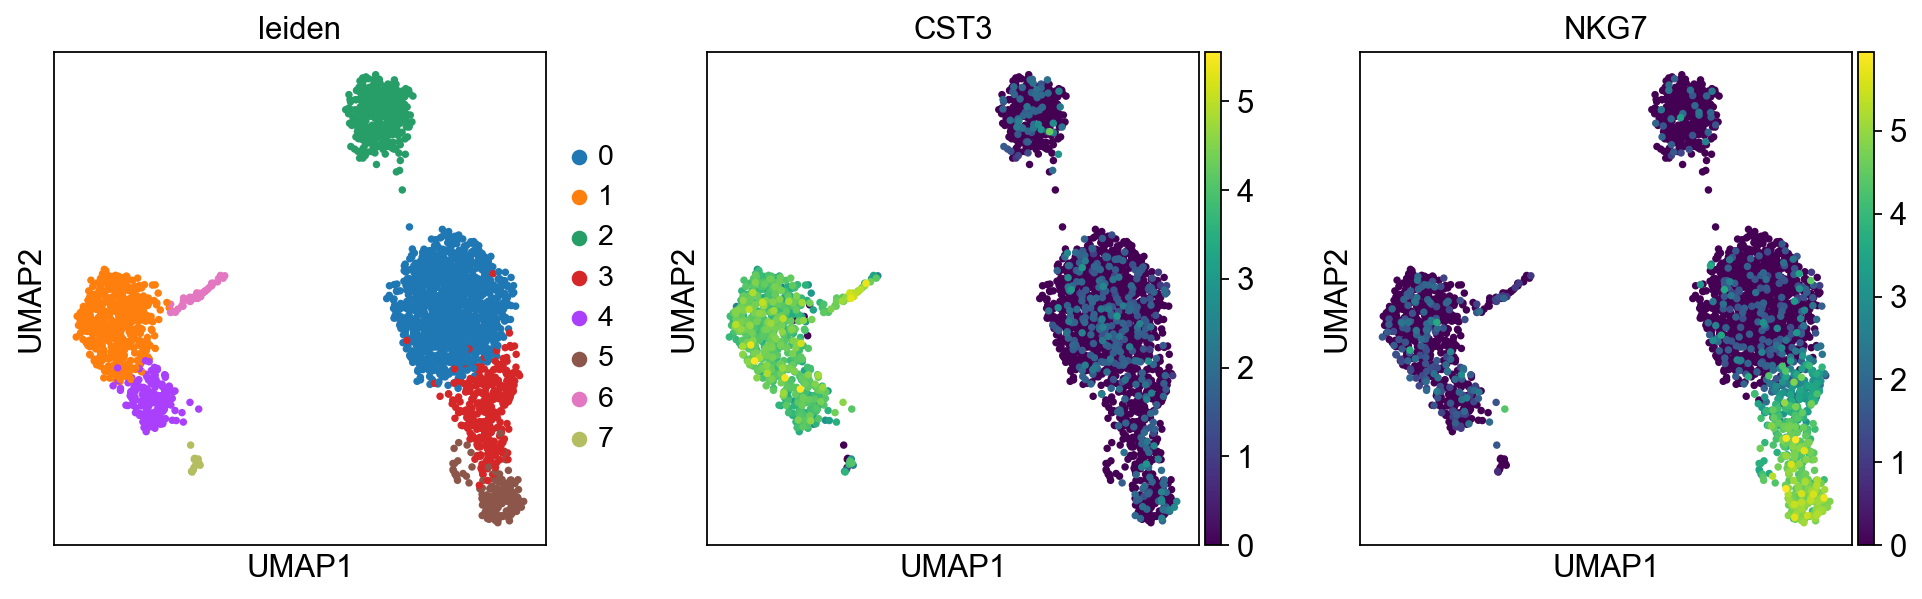

In [32]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [33]:
adata.write(results_file)

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


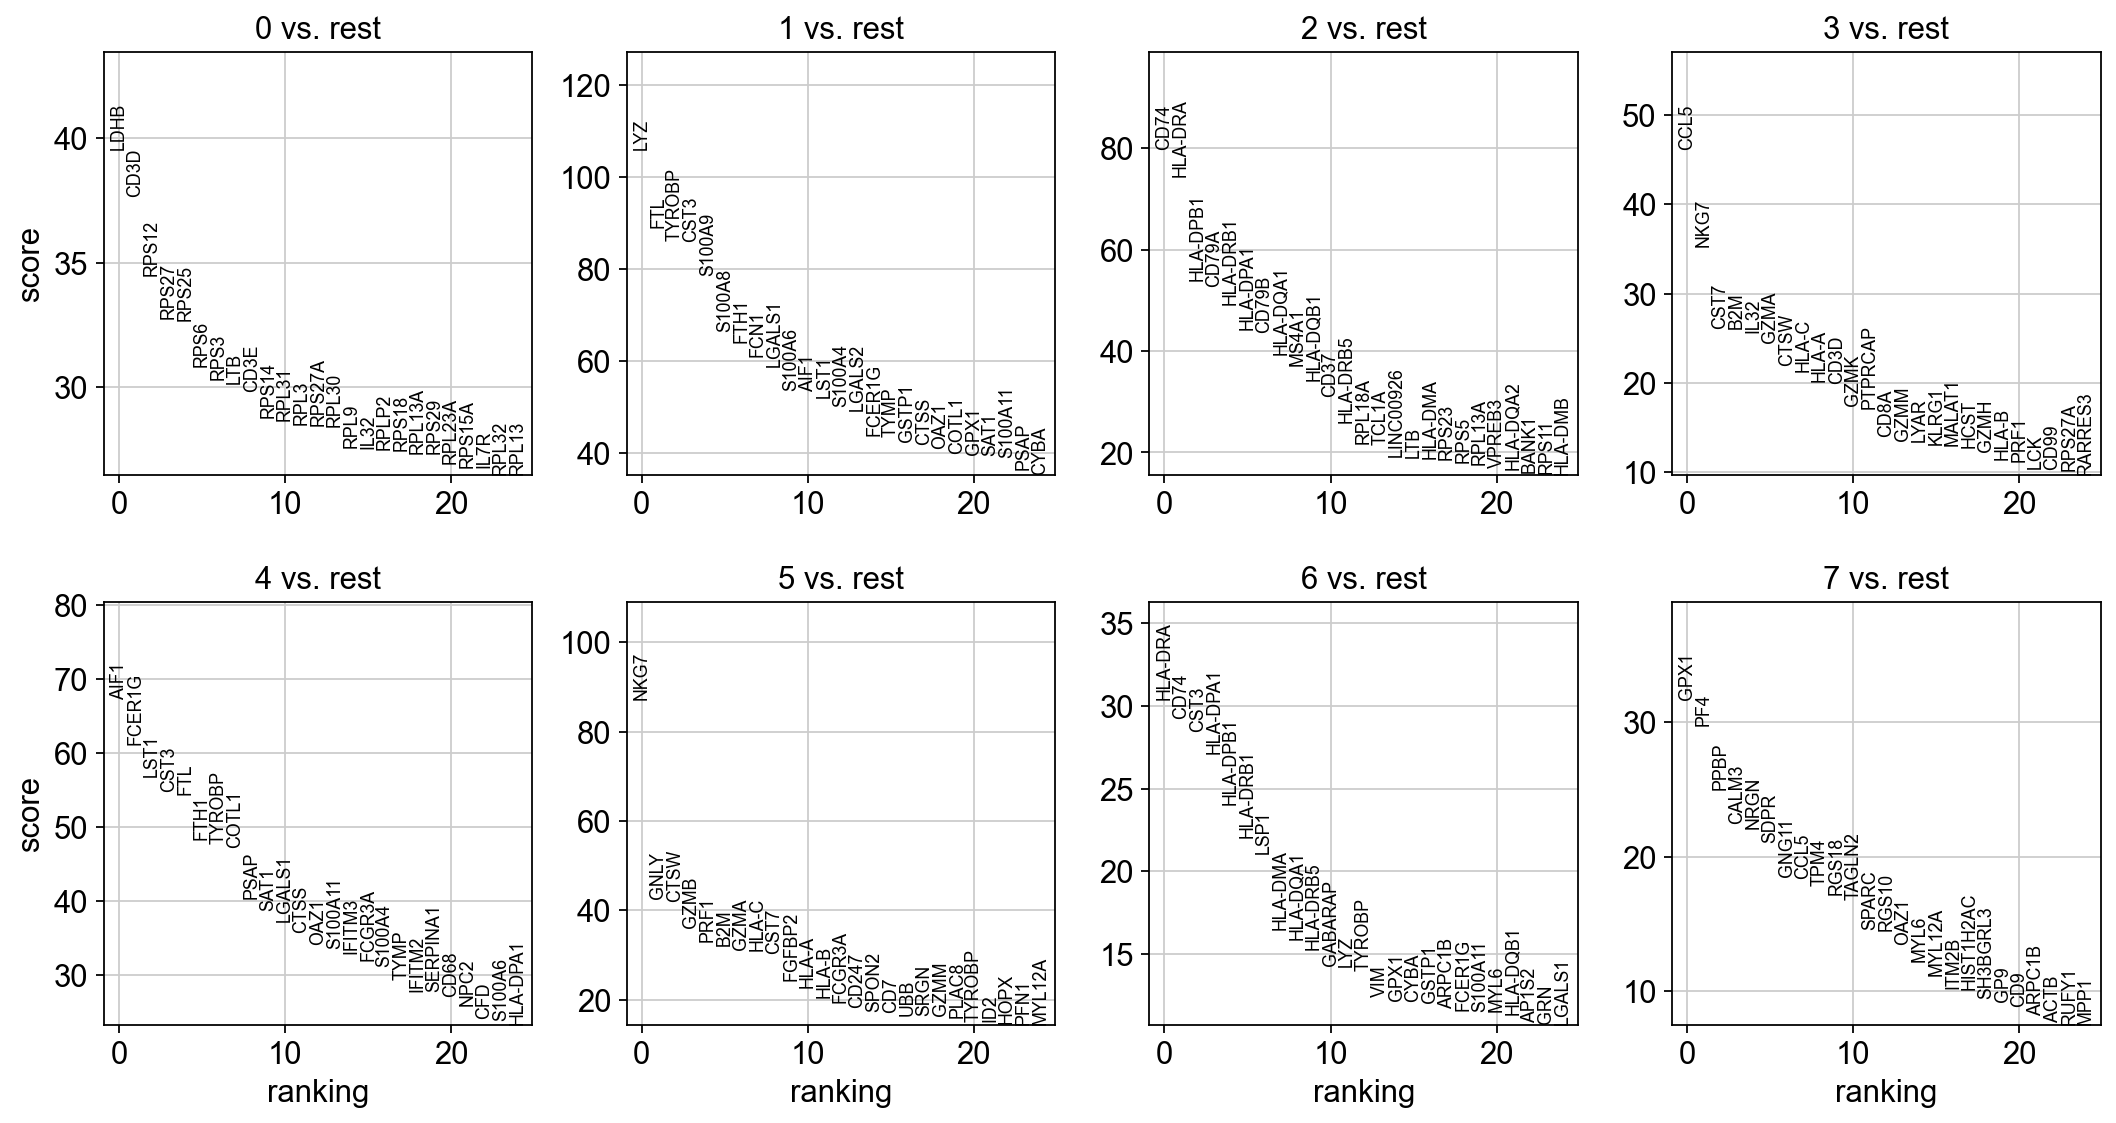

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:01)


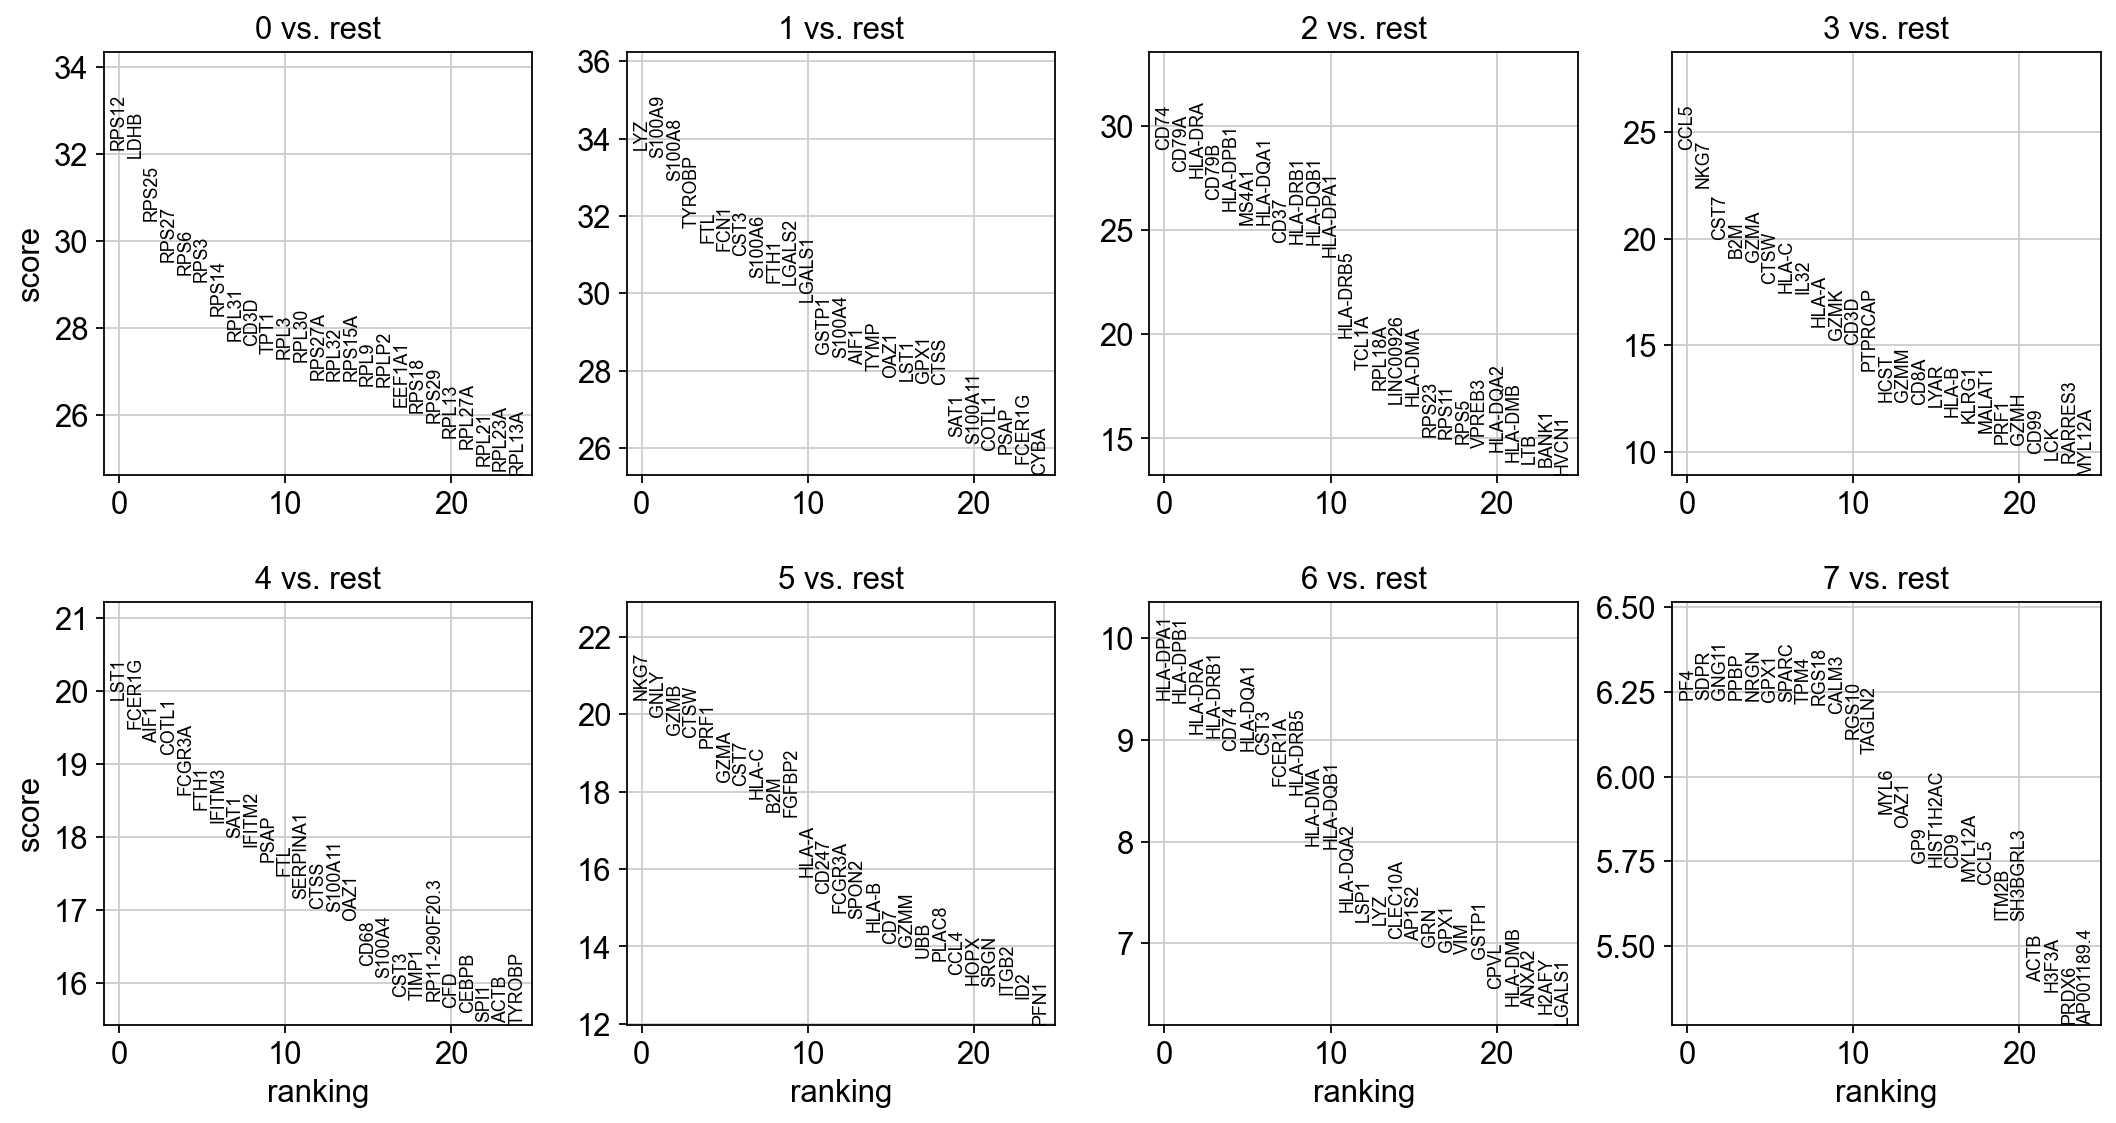

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
adata.write(results_file)

ranking genes
    finished (0:00:02)


/Users/cjerry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


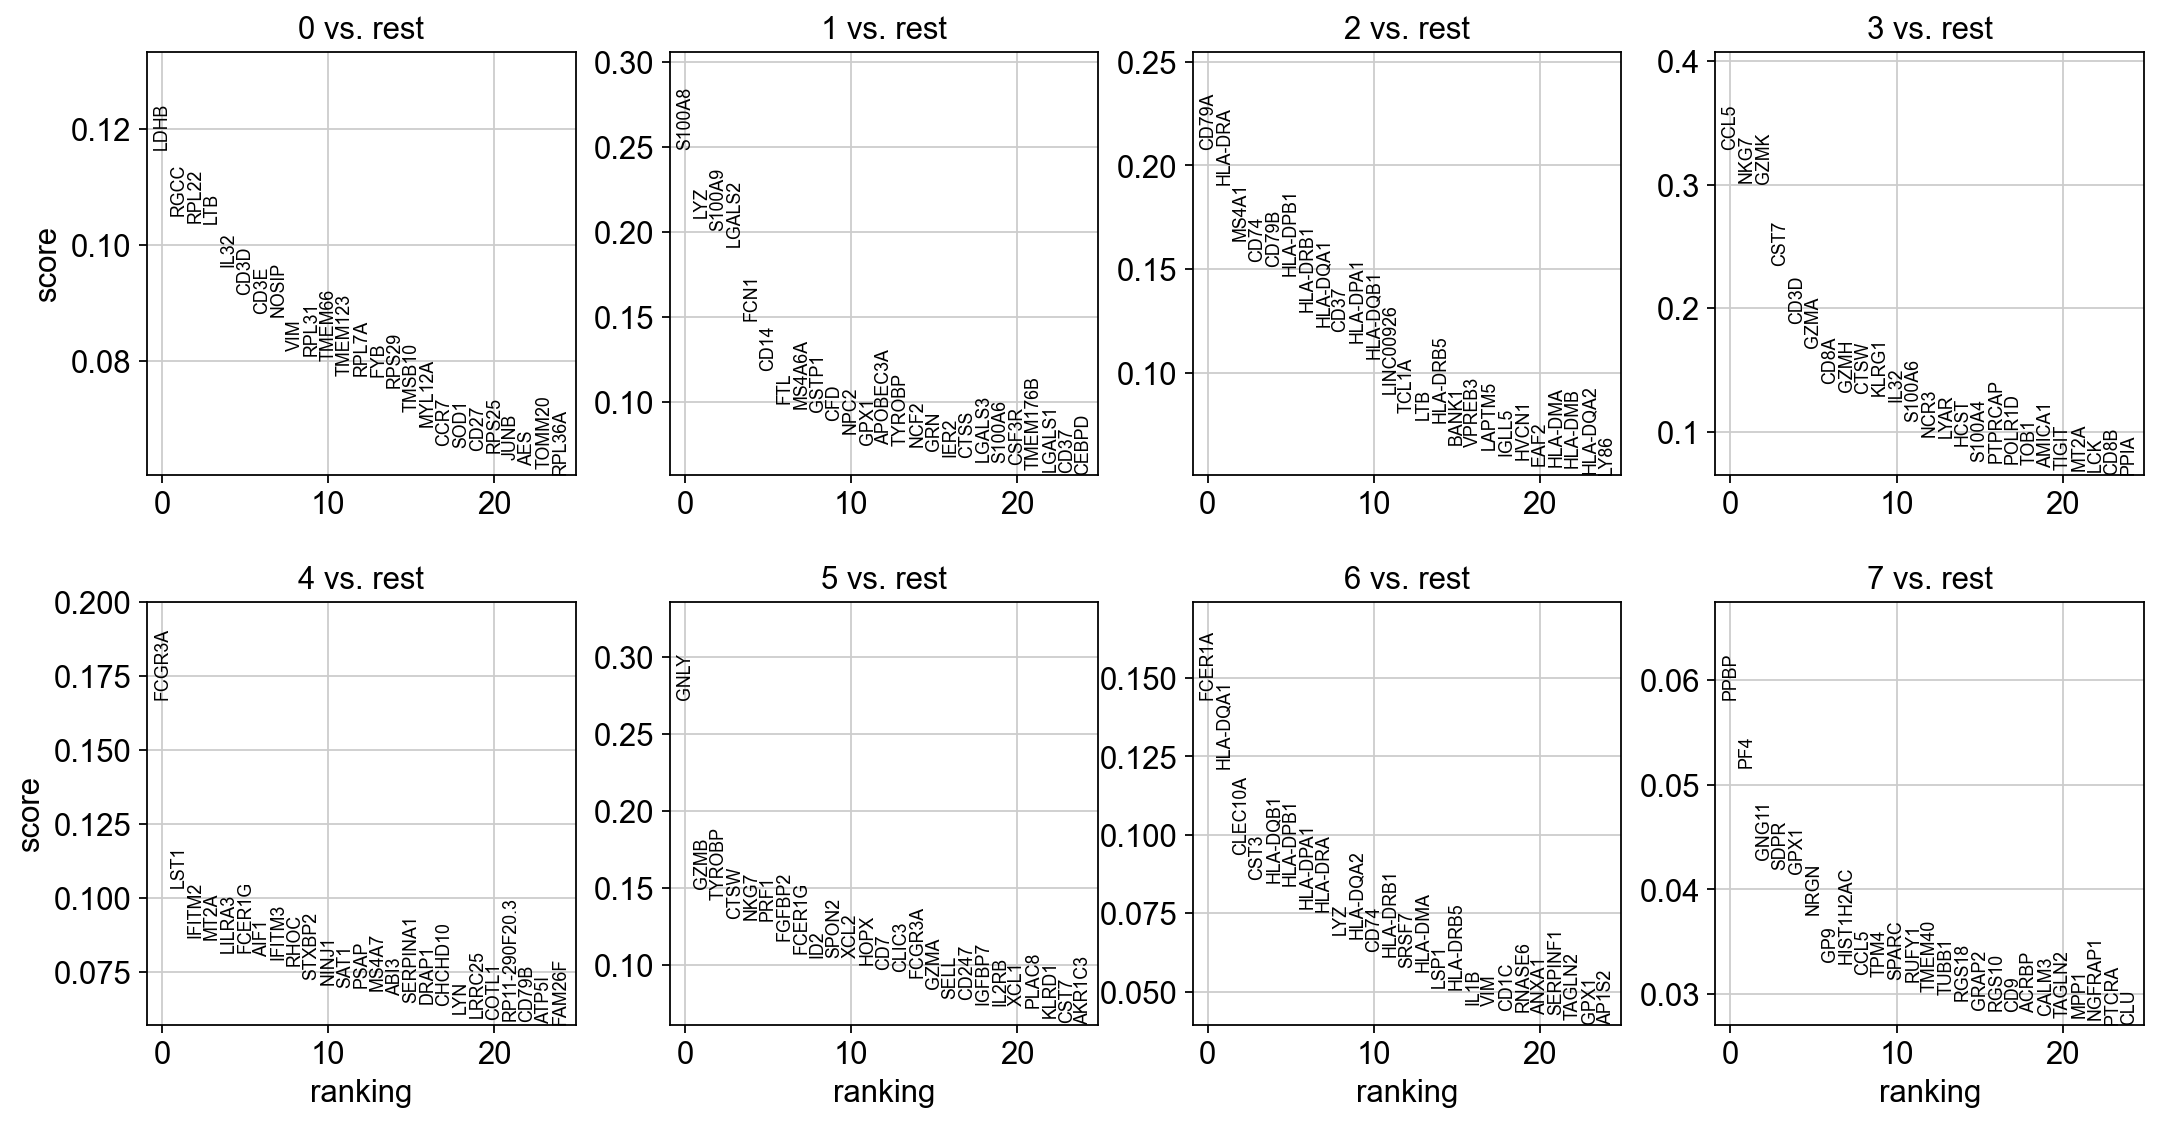

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

In [39]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [40]:
adata = sc.read(results_file)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [41]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,CST7,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,B2M,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,FCGR3A,PRF1,CD74,NRGN


In [42]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.164150e-226,LYZ,2.844372e-249,CD74,2.487145e-183,CCL5,3.790898e-129,LST1,4.980059e-88,NKG7,1.923512e-92,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,1.793331e-223,S100A9,2.654880e-246,CD79A,1.679730e-170,NKG7,2.905010e-111,FCER1G,1.449472e-84,GNLY,1.513503e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,4.641187e-204,S100A8,8.731315e-238,HLA-DRA,6.949695e-167,CST7,1.924488e-88,AIF1,5.839647e-83,GZMB,1.405777e-84,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.438482e-192,TYROBP,9.799314e-221,CD79B,2.569135e-154,B2M,1.938818e-81,COTL1,1.261406e-81,CTSW,7.510027e-84,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,5.780179e-188,FTL,3.676035e-215,HLA-DPB1,3.580735e-148,GZMA,5.438235e-80,FCGR3A,4.610698e-77,PRF1,1.053180e-81,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:00)


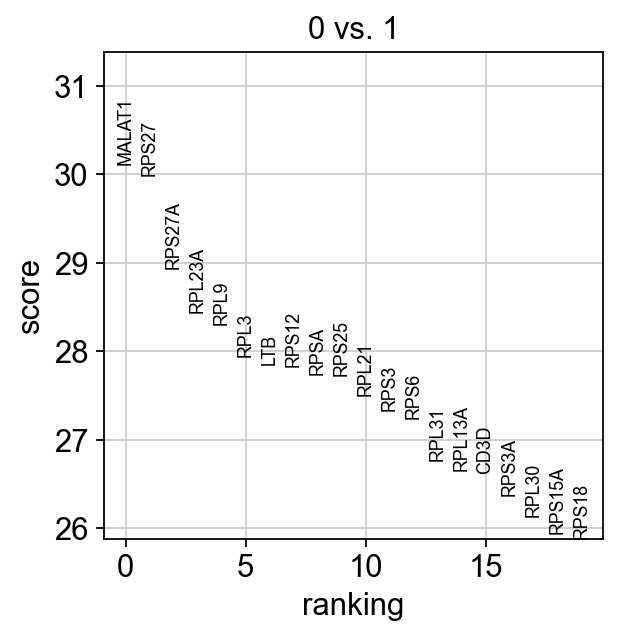

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


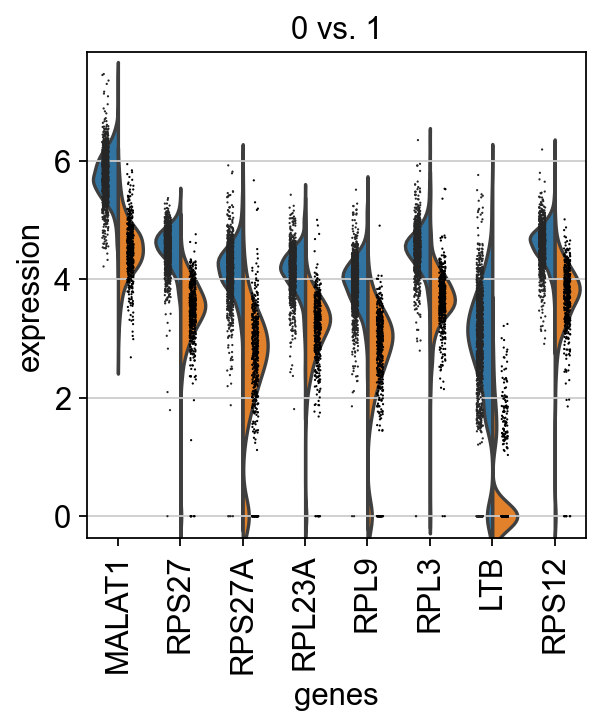

In [44]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [45]:
adata = sc.read(results_file)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/Users/cjerry/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


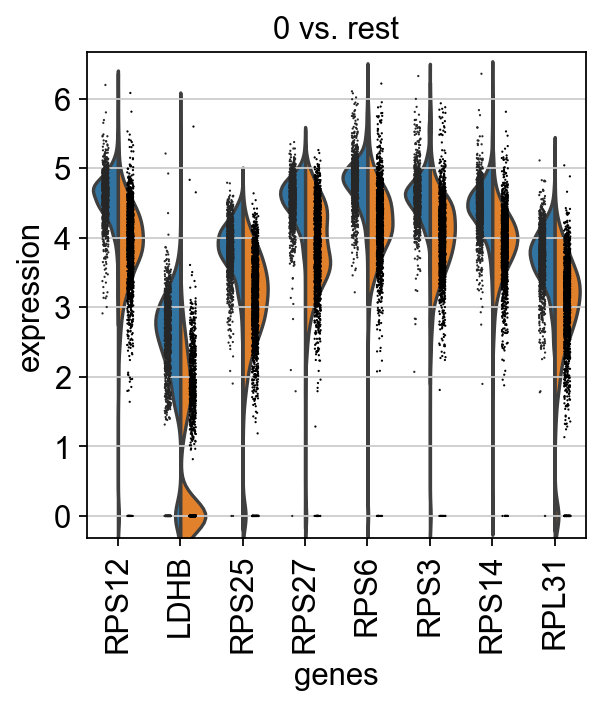

In [46]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

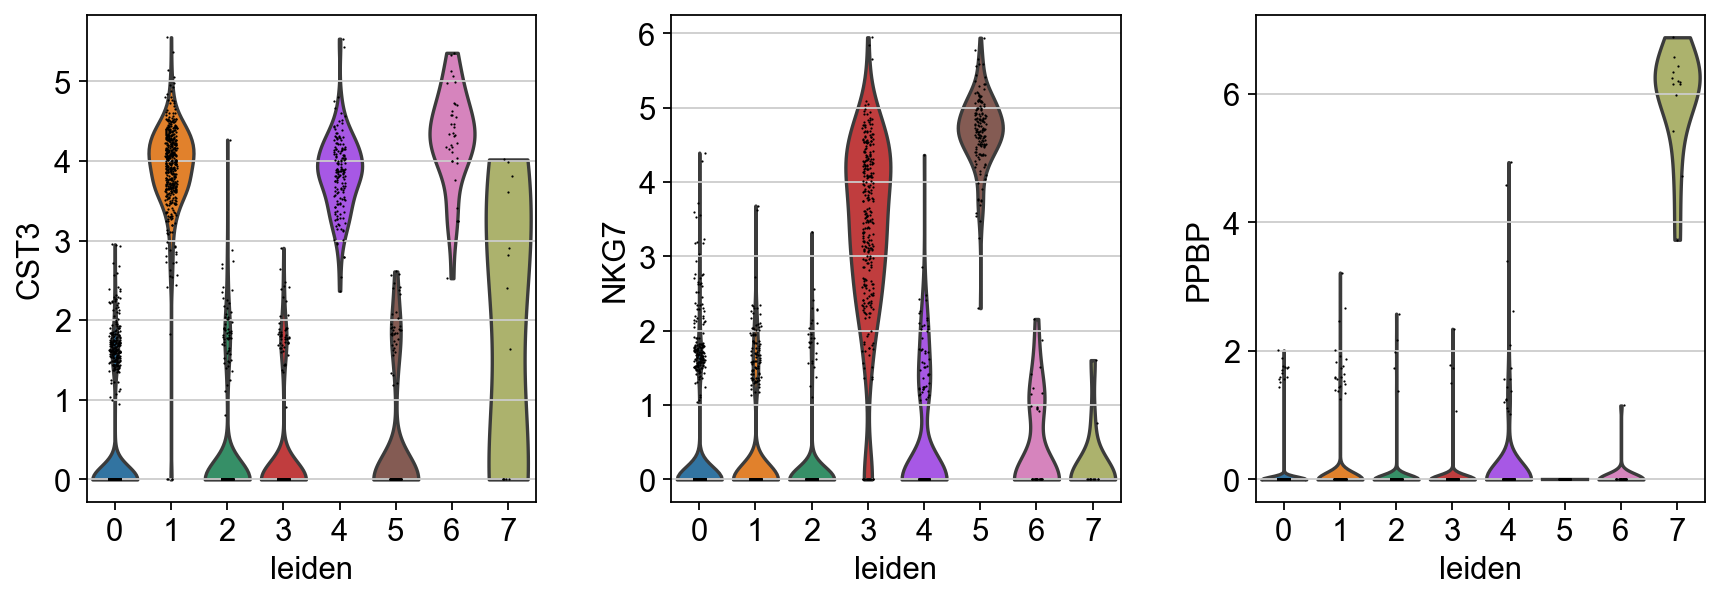

In [47]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

mark the cell types.

In [48]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


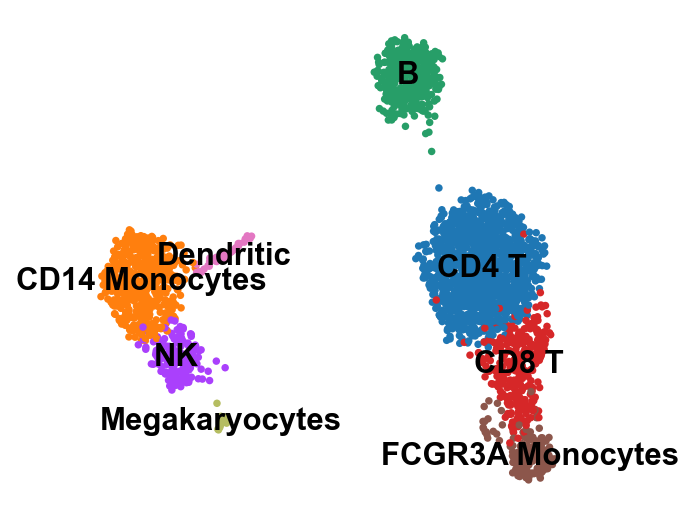

In [49]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

/Users/cjerry/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


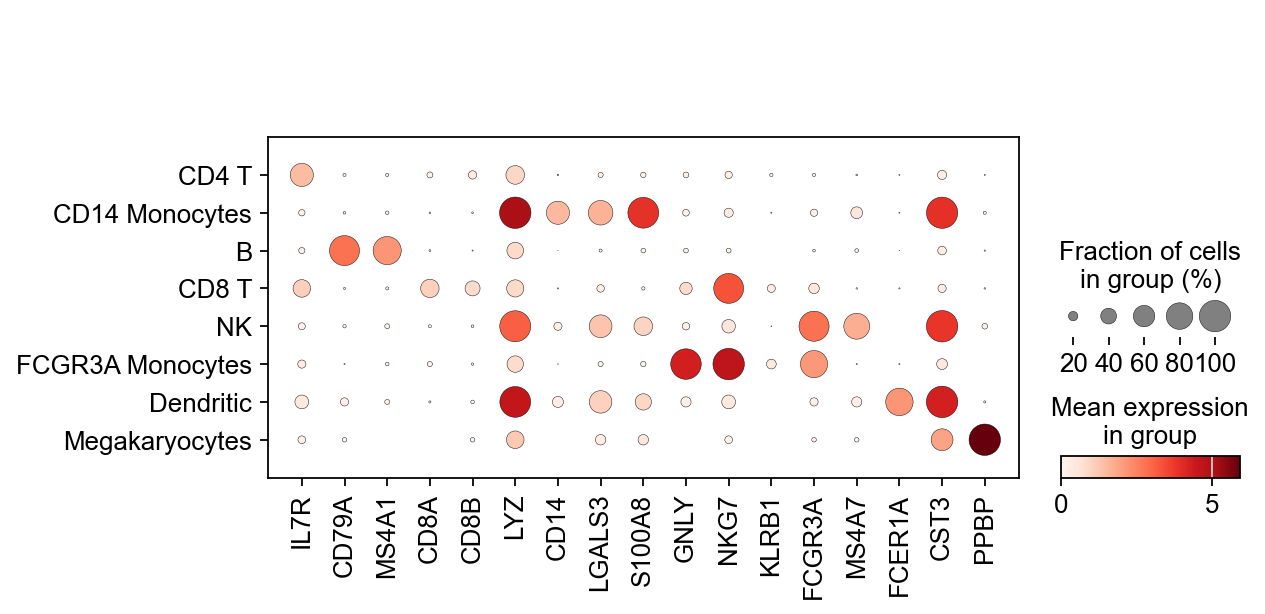

In [50]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

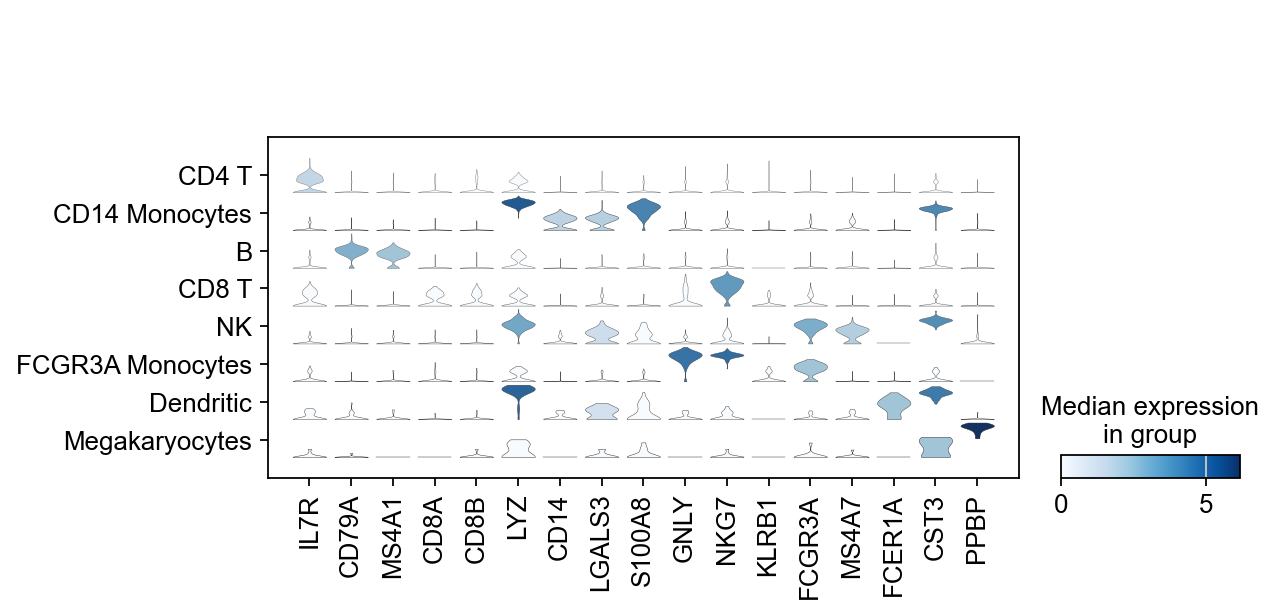

In [51]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

In [52]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [53]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [54]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

option to export to "csv":

In [55]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )